In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import datetime 
%matplotlib inline
app_dir = '/Users/nikhilvs/repos/nyu/covid-19'

In [123]:
curvefit_preds = pd.read_csv(os.path.join(app_dir, 'data/staging', 'curvefit_preds.csv'))
polyreg_preds = pd.read_csv(os.path.join(app_dir, 'data/staging', 'polyreg_preds.csv'))
arima_preds = pd.read_csv(os.path.join(app_dir, 'data/staging', 'arima_preds.csv'))


curvefit_preds['date'] = pd.to_datetime(curvefit_preds['date'], format='%Y-%m-%d') - datetime.timedelta(days = 33)
polyreg_preds['date'] = pd.to_datetime(polyreg_preds['date'], format='%Y-%m-%d')
arima_preds['date'] = pd.to_datetime(arima_preds['date'], format='%Y-%m-%d') - datetime.timedelta(days = 8)

curvefit_preds = curvefit_preds[(curvefit_preds['date'] > '2020-02-15') & (curvefit_preds['date'] < '2020-05-11')]
country = 'United States'

# curvefit_preds = curvefit_preds[curvefit_preds['country'] == country]
# polyreg_preds = polyreg_preds[polyreg_preds['country'] == country]
# arima_preds = arima_preds[arima_preds['country'] == country]

In [124]:
all_preds = polyreg_preds.merge(
    curvefit_preds,
    how = 'inner',
    left_on = ['country', 'date'],
    right_on = ['country', 'date']
).merge(
    arima_preds,
    how = 'inner',
    left_on = ['country', 'date'],
    right_on = ['country', 'date']
)[[
    'country',
    'date',
    'gt',
    'curvefit_preds',
    'polyreg_preds',
    'preds'
]]

all_preds['date'] = pd.to_datetime(all_preds['date'], format='%Y-%m-%d') + datetime.timedelta(days = 0)

In [125]:
arima_preds

,date,country,preds,lsups,linfs
0,2020-02-29,Brazil,-6.918879e+02,0.000000e+00,0.000000e+00
1,2020-03-01,Brazil,-1.395566e+02,0.000000e+00,0.000000e+00
2,2020-03-02,Brazil,2.898491e+02,0.000000e+00,0.000000e+00
3,2020-03-03,Brazil,-2.108209e+02,0.000000e+00,0.000000e+00
4,2020-03-04,Brazil,-1.520937e+02,0.000000e+00,0.000000e+00
...,...,...,...,...,...
871,2020-05-02,United States,1.336604e+06,1.344041e+06,1.329166e+06
872,2020-05-03,United States,1.354908e+06,1.366692e+06,1.343124e+06
873,2020-05-04,United States,1.375297e+06,1.391735e+06,1.358859e+06
874,2020-05-05,United States,1.398375e+06,1.420002e+06,1.376748e+06


In [126]:

all_preds['ensemble'] = (all_preds['curvefit_preds'] + all_preds['polyreg_preds'] + all_preds['preds']) / 3

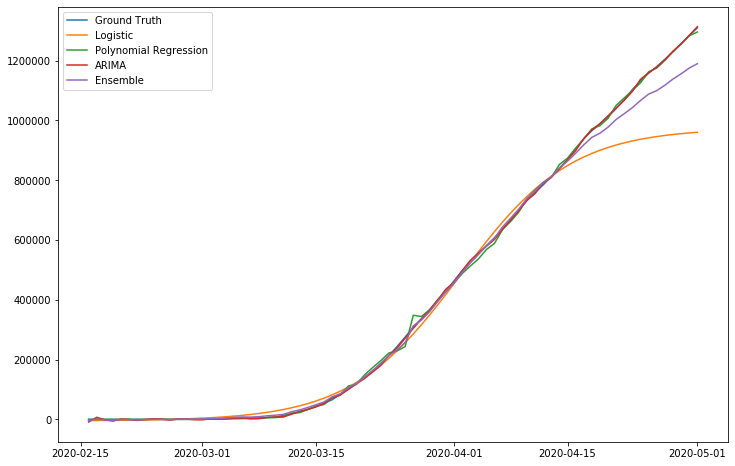

In [162]:
plt.figure(figsize = (12, 8))

x = all_preds[all_preds['country'] == 'United States']

plt.plot(x['date'], x['gt'], label = 'Ground Truth')
plt.plot(x['date'], x['curvefit_preds'], label = 'Logistic')
plt.plot(x['date'], x['polyreg_preds'], label = 'Polynomial Regression')
plt.plot(x['date'], x['preds'], label = 'ARIMA')
plt.plot(x['date'], x['ensemble'], label = 'Ensemble')
plt.legend()
plt.savefig(os.path.join(app_dir, 'plots', 'us_all.png'))

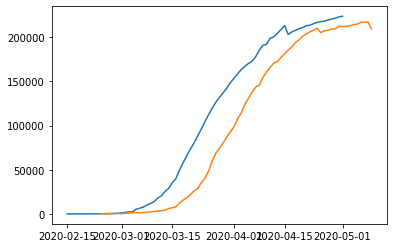

In [92]:
plt.plot(polyreg_preds['date'], polyreg_preds['gt'])
plt.plot(all_preds['date'], all_preds['ensemble'])

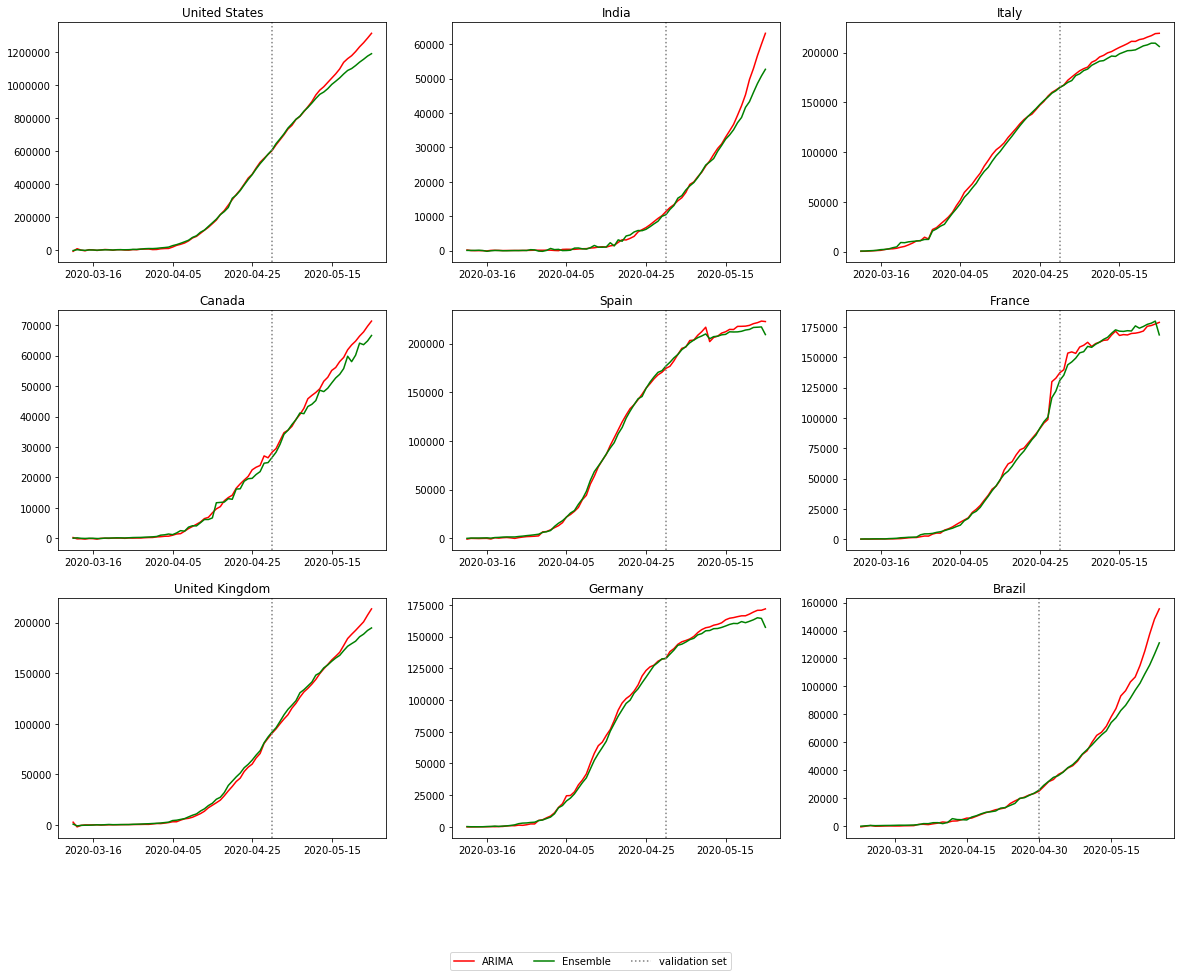

In [176]:
import matplotlib.dates as mdates 
import matplotlib.ticker as tkr

fig, (
    (ax11, ax12, ax13), 
    (ax21, ax22, ax23),
    (ax31, ax32, ax33)
    # (ax41, ax42, ax43)
) = plt.subplots(3, 3)
# fig.suptitle('Sharing x per column, y per row')

fig.set_figwidth(20)
fig.set_figheight(15)
axes = [ax11, ax12, ax13, ax21, ax22, ax23, ax31, ax32, ax33, ax41, ax42, ax43]
# countries = all_preds['country'].unique()
countries = [
    'United States', 
    'India', 
    'Italy', 
    'Canada', 
    'Spain', 
    'France', 
    'United Kingdom',
    # 'Iraq',
    # 'Japan',
    # 'South Korea',
    'Germany',
    'Brazil'
]

countries_with_preds = all_preds
all_preds['date'] = pd.to_datetime(all_preds['date']) + datetime.timedelta(days = 8)
for country, ax in zip(countries, axes):

    country_preds = countries_with_preds[countries_with_preds['country'] == country]
    # dates = np.arange(country_preds.shape[0])
    dates = country_preds['date']
    ax.plot(dates, country_preds['preds'], 'r-', label = 'ARIMA')
    # ax.plot(dates, country_preds['gt'], 'b-', label = 'Ground Truth')
    # ax.plot(dates, country_preds['curvefit_preds'], 'm-', label = 'Logistic Curve')
    # ax.plot(dates, country_preds['polyreg_preds'], 'g-', label = 'Polynomial Regression')
    ax.plot(dates, country_preds['ensemble'], 'g-', label = 'Ensemble')
    
    locator = tkr.MaxNLocator(nbins=5)
    ax.xaxis.set_major_locator(locator)
    ax.axvline(x=datetime.datetime(2020, 4, 30), color = 'gray', linestyle = ':', label = 'validation set')
    # ax.axvline(x=datetime.datetime(2020, 4, 30))
    ax.set_title(country)
    # ax.legend()

handles, labels = ax13.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol = 5)

app_dir = '/Users/nikhilvs/repos/nyu/covid-19'
plt.savefig(os.path.join(app_dir, 'plots', 'ensemble.png'), dpi=100, bbox_inches = 'tight', pad_inches = 0)

In [158]:
app_dir = '/Users/nikhilvs/repos/nyu/covid-19'
plt.savefig(os.path.join(app_dir, 'plots', 'ensemble.png'), dpi=100, bbox_inches = 'tight', pad_inches = 0)

<Figure size 432x288 with 0 Axes>

In [174]:

for col in ['curvefit_preds', 'polyreg_preds', 'preds', 'ensemble']:
    x = all_preds[all_preds['date'] > '2020-04-30']
    print(col, sum((x['gt'] - x[col]) ** 2) / x.shape[0])

curvefit_preds 4008580605.761416
polyreg_preds 23563208.33916526
preds 5562383.552539598
ensemble 458310932.0195745


In [175]:
x

,country,date,gt,curvefit_preds,polyreg_preds,preds,ensemble
59,United States,2020-05-01,869170.0,849146.687244,873812.177231,868188.366229,863715.743568
60,United States,2020-05-02,905358.0,864240.405099,907278.695170,898973.822820,890164.307696
61,United States,2020-05-03,938154.0,877711.336081,937649.534420,939419.987189,918260.285897
62,United States,2020-05-04,965785.0,889685.438571,971514.678156,968956.739484,943385.618737
63,United States,2020-05-05,988197.0,900290.839189,982649.527241,989396.509633,957445.625354
...,...,...,...,...,...,...,...
806,Brazil,2020-05-13,115455.0,74297.183704,117546.539701,115046.176717,102296.633374
807,Brazil,2020-05-14,126611.0,75590.588510,125918.506079,125429.073476,108979.389355
808,Brazil,2020-05-15,135773.0,76772.396701,131651.802547,137434.048613,115286.082620
809,Brazil,2020-05-16,146894.0,77848.651287,143052.849346,148160.347762,123020.616132


In [166]:
all_preds.columns

Index(['country', 'date', 'gt', 'curvefit_preds', 'polyreg_preds', 'preds',
       'ensemble'],
      dtype='object')